In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2204]:
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression
from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite, bandpass_velocity, interp_in_space, integral, compute_ape, bandpass_variable
from qc import qc_turbulence, qc_velocity

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [2041]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')

In [2042]:
# need to relax the qc criteria a bit because of heaving due to larger surface gravity waves
raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))

In [2043]:
# background_raw = raw.sel(time=slice('2016-10-04','2016-10-21'))
background_cfs = cfs.sel(time=slice('2016-09-25','2016-10-02'))
background_raw = raw.sel(time=slice('2016-09-25','2016-10-02'))

In [2044]:
raw = raw.sel(time=slice('2016-10-04','2016-10-21'))
cfs = cfs.sel(time=slice('2016-10-04','2016-10-21'))

In [2045]:
( dsp.get_sampling_step(raw, dim='time')*1e-9 )

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UnevenSamplingWarning: Average sampling 6.4e+12 != first sampling step 9.73e+12
  """Entry point for launching an IPython kernel.


6399.0617841198355

In [2046]:
ny = 0.5/(60*60)
gsw.f(40.7)/ny

0.6847454234948632

In [2105]:
# bandpass between low*f and high*f
f = gsw.f(40.7)/(2*np.pi)
raw = bandpass_velocity(raw, 0.75*f, 1.25*f)

0.14528610105438827
0.24214350175731378


../src/tools.py:116: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  # determine sampling timestep and Nyquist frequency


## Horizontal kinetic energy (HKE)

In [2106]:
mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)

In [2107]:
rho0=raw.rho0.mean()
raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2) # that gonna be in [J m^{-3}]
raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)

In [2401]:
raw['hkefake'] = 0.5*rho0*( (raw.uNI+0.1)**2 + raw.vNI**2)

(-300, 0)

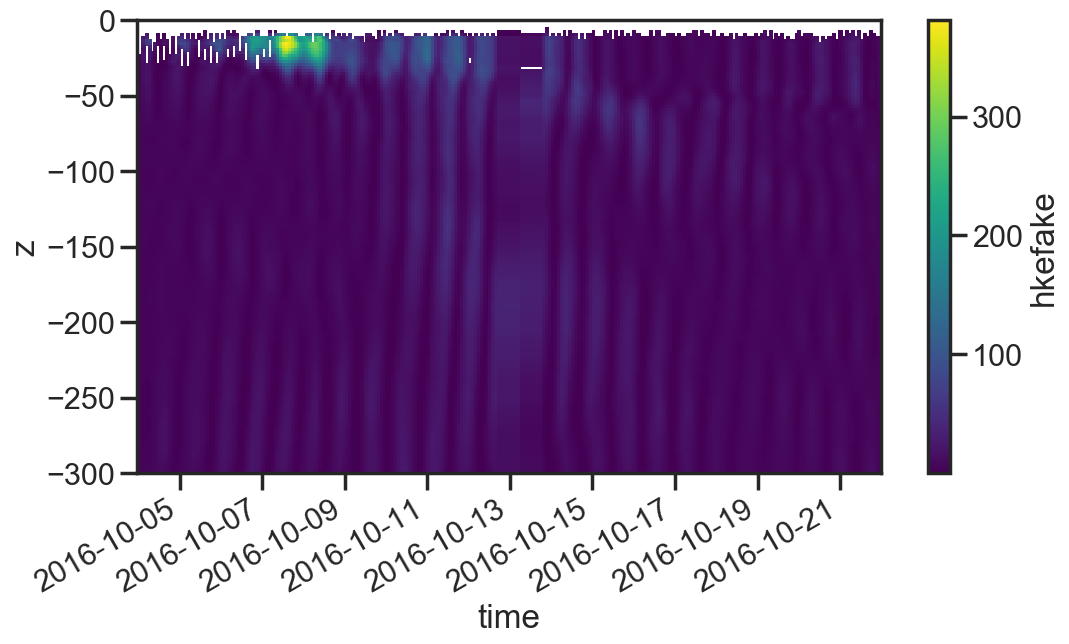

In [2402]:
raw.hkefake.plot()
plt.ylim(zmin,0)

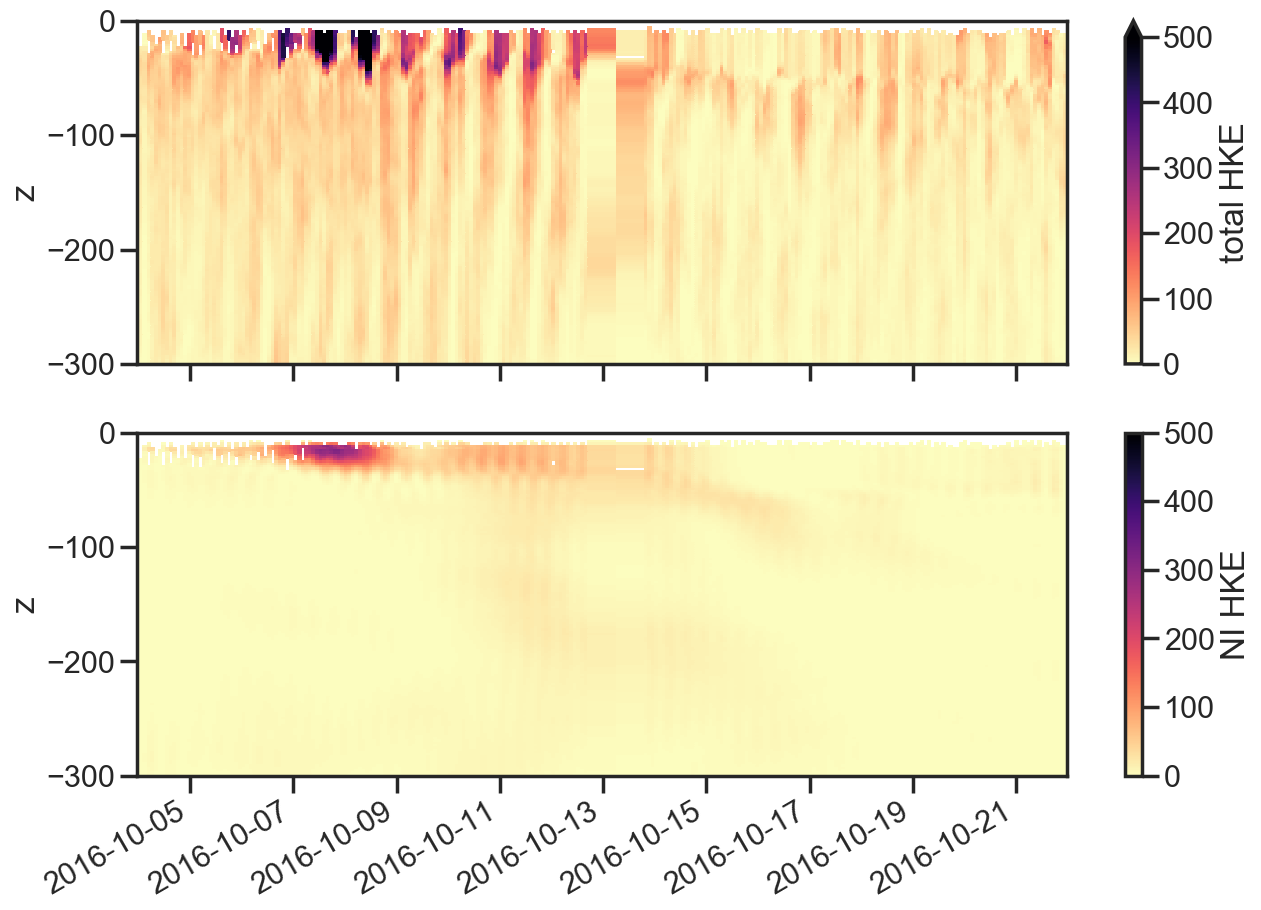

In [2396]:
zmin = -300
f, (ax0, ax1) = plt.subplots(2,1,figsize=(15,10), sharex=True) 
raw.hkeTOT.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax0, cbar_kwargs={'label': 'total HKE'})
ax0.set_ylim(zmin,0)
ax0.set_xlabel(None)

raw.hkeNI.where(mask).plot(cmap='magma_r',vmin=0, vmax=500, ax=ax1, cbar_kwargs={'label': 'NI HKE'})
ax1.set_ylim(zmin,0)
ax1.set_xlabel(None);

In [2239]:
raw['dudz'] = raw.u.differentiate('z',)
raw['dvdz'] = raw.v.differentiate('z')
raw['S'] = 0.5*(raw.dudz**2 + raw.dvdz**2)

raw['dudzNI'] = raw.uNI.differentiate('z')
raw['dvdzNI'] = raw.vNI.differentiate('z')
raw['SNI'] = 0.5*(raw.dudzNI**2 + raw.dvdzNI**2)

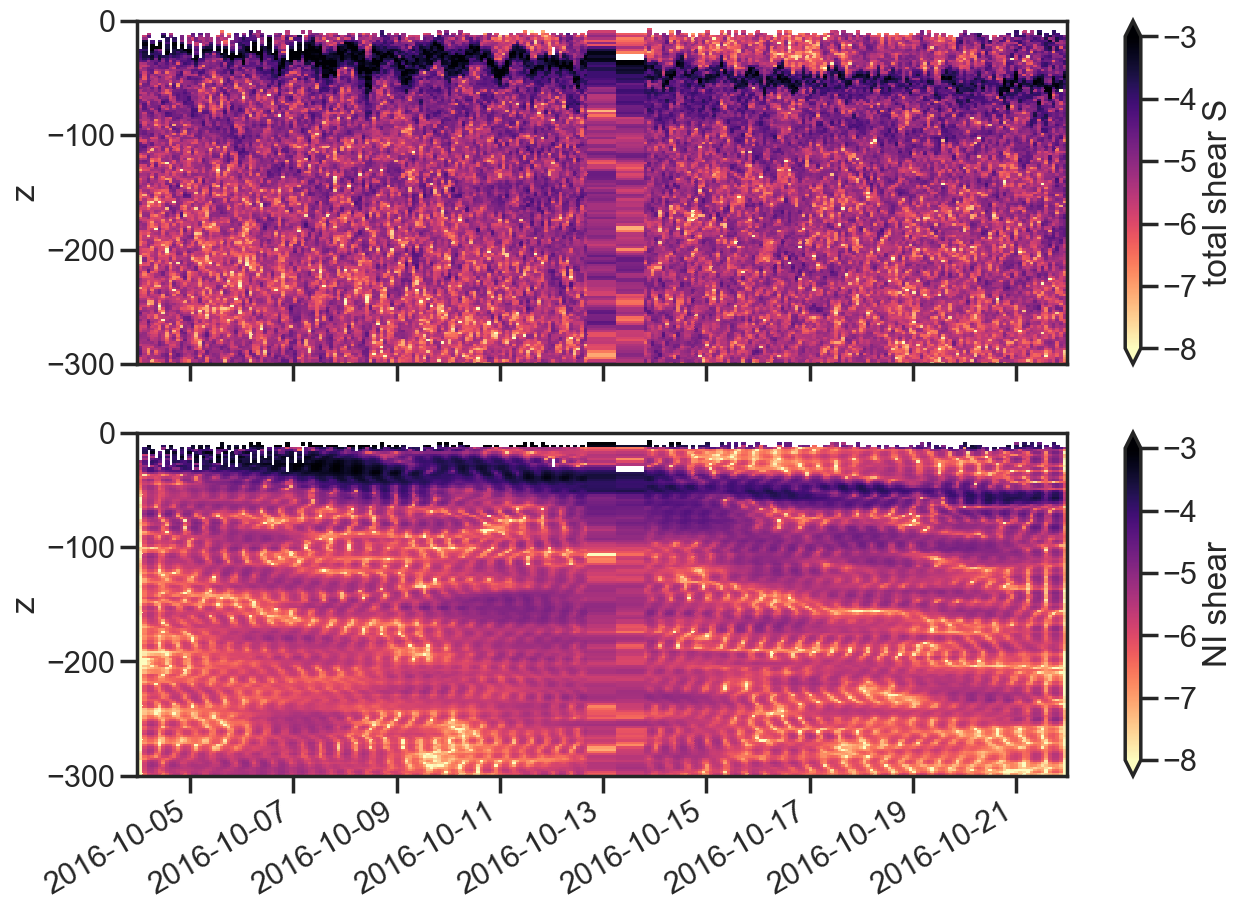

In [2352]:
zmin = -300
f, (ax0, ax1) = plt.subplots(2,1,figsize=(15,10), sharex=True) 
raw.S.pipe(np.log10).plot(cmap='magma_r',vmin=-8, vmax=-3, ax=ax0, cbar_kwargs={'label': 'total shear S'})
ax0.set_ylim(zmin,0)
ax0.set_xlabel(None)

raw.SNI.pipe(np.log10).plot(cmap='magma_r',vmin=-8, vmax=-3, ax=ax1, cbar_kwargs={'label': 'NI shear'})
ax1.set_ylim(zmin,0)
ax1.set_xlabel(None);

In [2256]:
dfdu = 0.5*( compute_spectra(raw,'dudz').mean('dtime')**2 + compute_spectra(raw,'dvdz').mean('dtime')**2)
dfduNI =  0.5*( compute_spectra(raw,'dudzNI').mean('dtime')**2 + compute_spectra(raw,'dvdzNI').mean('dtime')**2)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.


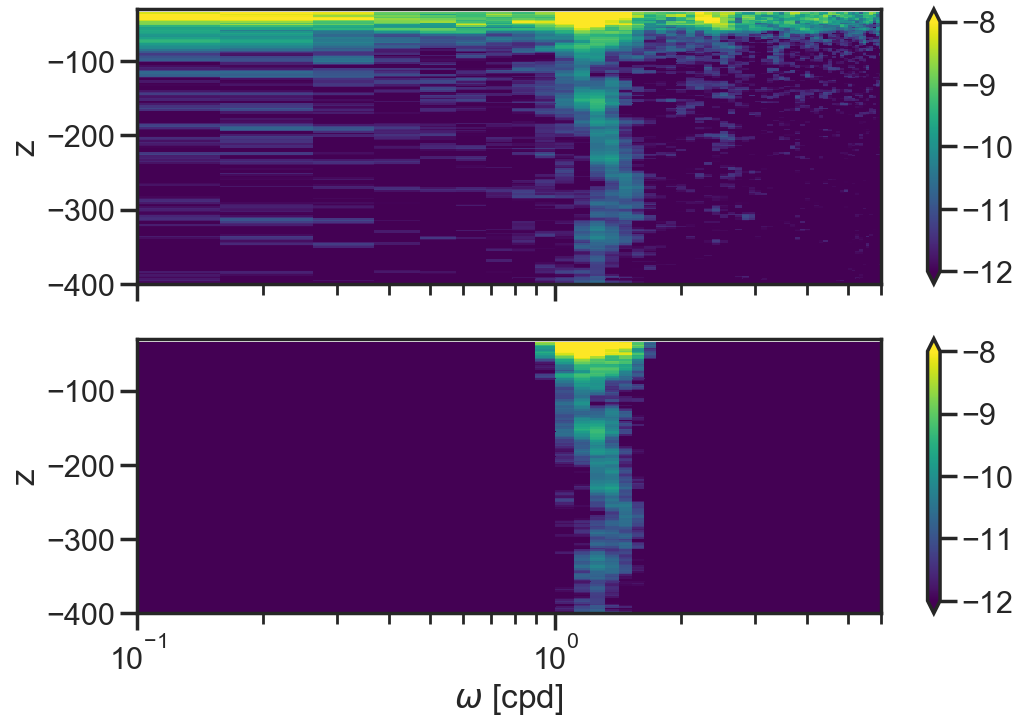

In [2261]:
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True) 

dfdu.pipe(np.log10).plot(cmap='viridis',vmin=-12, vmax=-8, ax=ax[0])
ax[0].set_ylim(-400,-30)
ax[0].set_xlim(1e-1,6e0)
ax[0].set_title(None);
ax[0].set_xlabel(None)
ax[0].set_xscale('log')

dfduNI.pipe(np.log10).plot(cmap='viridis',vmin=-12, vmax=-8, ax=ax[1])
ax[1].set_ylim(-400,-30)
ax[1].set_xlim(1e-1,6e0)
ax[1].set_title(None);
ax[1].set_xlabel('$\omega$ [cpd]')
ax[1].set_xscale('log')

In [2109]:
from scipy import signal
import xrscipy.signal as dsp

In [2189]:
def compute_spectra(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all'), dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

In [2190]:
dfu = compute_spectra(raw,'u').mean('dtime')
dfv = compute_spectra(raw,'v').mean('dtime')
dft = 0.5*(dfu+dfv)

dfniu = compute_spectra(raw,'uNI').mean('dtime')
dfniv = compute_spectra(raw,'vNI').mean('dtime')
dfnit = 0.5* (dfniu+dfniv)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.


/usr/local/anaconda3/lib/python3.7/site-packages/xarray/plot/plot.py:965: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(x[0], x[-1])


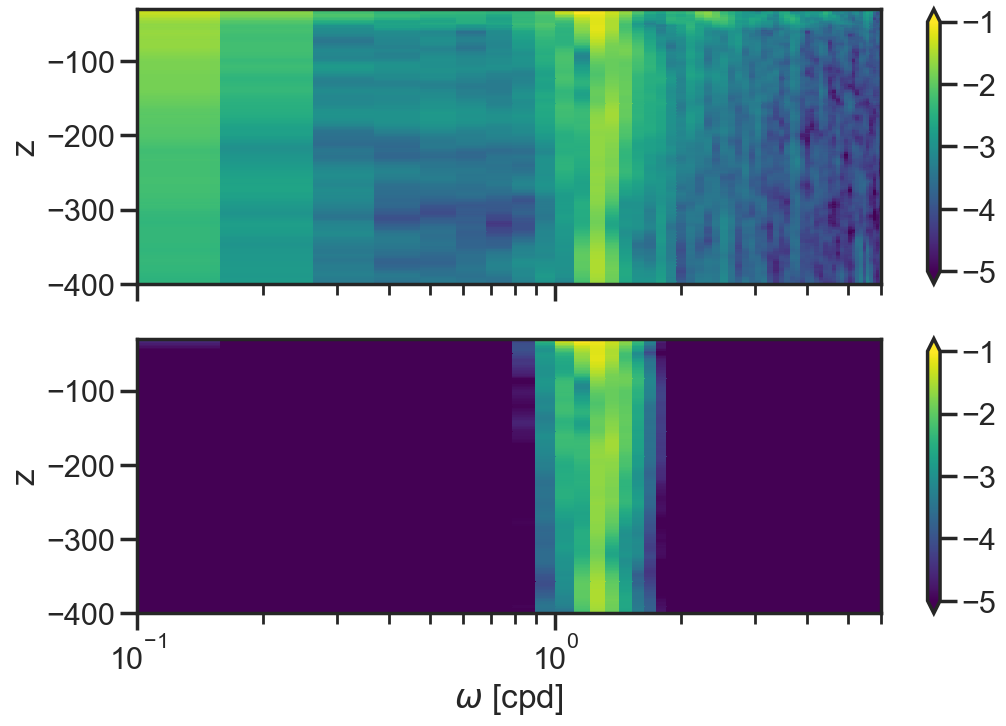

In [2191]:
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True) 

dft.pipe(np.log10).plot(cmap='viridis', vmin=-5, vmax=-1, ax=ax[0])
ax[0].set_ylim(-400,-30)
ax[0].set_xlim(1e-1,6e0)
ax[0].set_title(None);
ax[0].set_xlabel(None)
ax[0].set_xscale('log')

dfnit.pipe(np.log10).plot(cmap='viridis', vmin=-5, vmax=-1, ax=ax[1])
ax[1].set_ylim(-400,-30)
ax[1].set_xlim(1e-1,6e0)
ax[1].set_title(None);
ax[1].set_xlabel('$\omega$ [cpd]')
ax[1].set_xscale('log')

In [2192]:
gsw.f(40)*86400/(2*np.pi)

1.2890948565868658

In [2193]:
dft.pipe(np.log10).squeeze().hvplot(x='frequency', groupby='z')*dfnit.pipe(np.log10).squeeze().hvplot(x='frequency', groupby='z',)

:DynamicMap   [z]
   :Overlay
      .NdOverlay.I  :NdOverlay   [pressure]
         :Curve   [frequency]   (value)
      .NdOverlay.II :NdOverlay   [pressure]
         :Curve   [frequency]   (value)

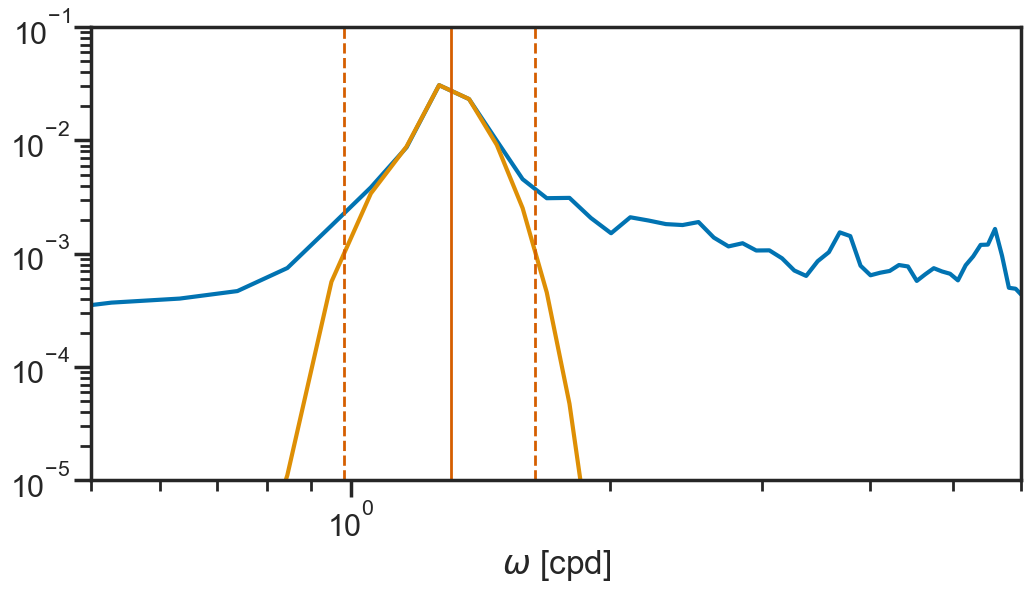

In [2194]:
(dft*dft.frequency).mean('z').plot(label='total')
(dfnit*dfnit.frequency).mean('z').plot(label='bandpass')

latmean = 40.7
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')


plt.xlim(5e-1,6e0)
plt.ylim(1e-5,1e-1)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')
plt.yscale('log')

In [2195]:
# integrate energy vertically
# raw = raw.swap_dims({'dtime':'time'})
zmin = -300
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['hke_ml_ni'] = ('time', integrate_columns(raw.hkeNI, raw.mld,0))
raw['hke_py_ni'] = ('time', integrate_columns(raw.hkeNI, zmin, raw.mld))
raw['hke_ml'] = ('time', integrate_columns(raw.hkeTOT, raw.mld,0))
raw['hke_py'] = ('time', integrate_columns(raw.hkeTOT, zmin, raw.mld))

In [2196]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['hke_ml_ni'] = raw.hkeNI.where(ml_mask).mean(dim='z')
raw['hke_py_ni'] = raw.hkeNI.where(py_mask).mean(dim='z')
raw['hke_ml'] = raw.hkeTOT.where(ml_mask).mean(dim='z')
raw['hke_py'] = raw.hkeTOT.where(py_mask).mean(dim='z')

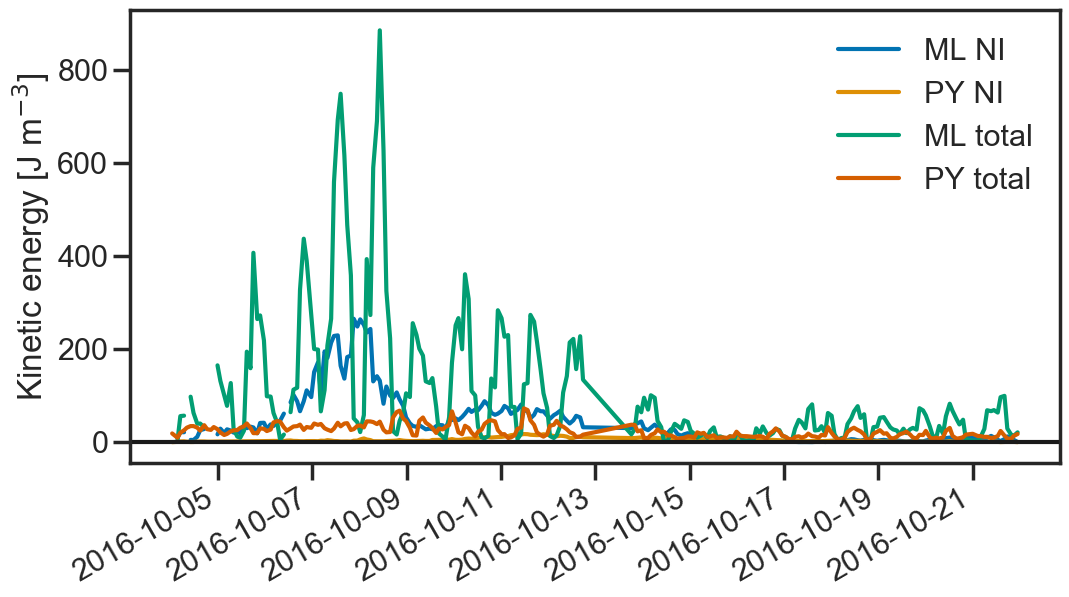

In [2197]:
raw['hke_ml_ni'].plot(label='ML NI')
raw['hke_py_ni'].plot(label='PY NI')
raw['hke_ml'].plot(label='ML total')
raw['hke_py'].plot(label='PY total')
plt.ylabel('Kinetic energy [J m$^{-3}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend();

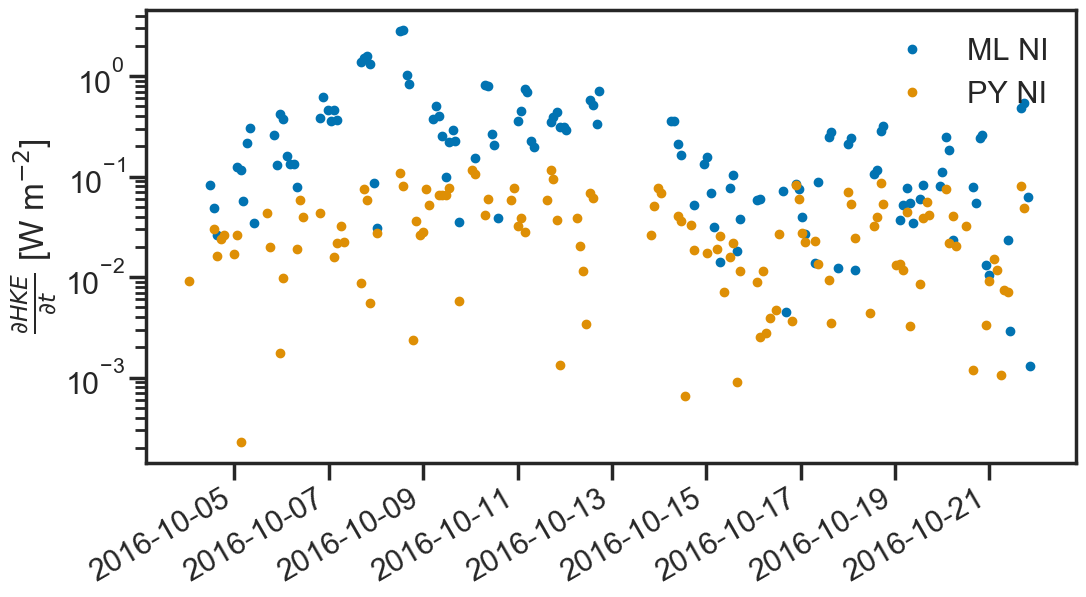

In [2198]:
# take time derivatvies
raw['dhke_ml'] = (raw['hke_ml']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_ml_ni'] = (raw['hke_ml_ni']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_py'] = (raw['hke_py']*raw.mld).differentiate('time',datetime_unit='s')
raw['dhke_py_ni'] = (raw['hke_py_ni']*raw.mld).differentiate('time',datetime_unit='s')

raw.dhke_ml.plot(label='ML NI', marker='.', lw=0)
raw.dhke_py.plot(label='PY NI', marker='.', lw=0)

# (raw['hke_ml_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='ML NI')
# (raw['hke_py_ni'].differentiate('time',datetime_unit='s')*raw.mld).plot(label='PY NI')
# raw['hke_ml'].differentiate('time',datetime_unit='s').plot(label='ML total')
# raw['hke_py'].differentiate('time',datetime_unit='s').plot(label='PY total')

plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.legend();
plt.yscale('log')

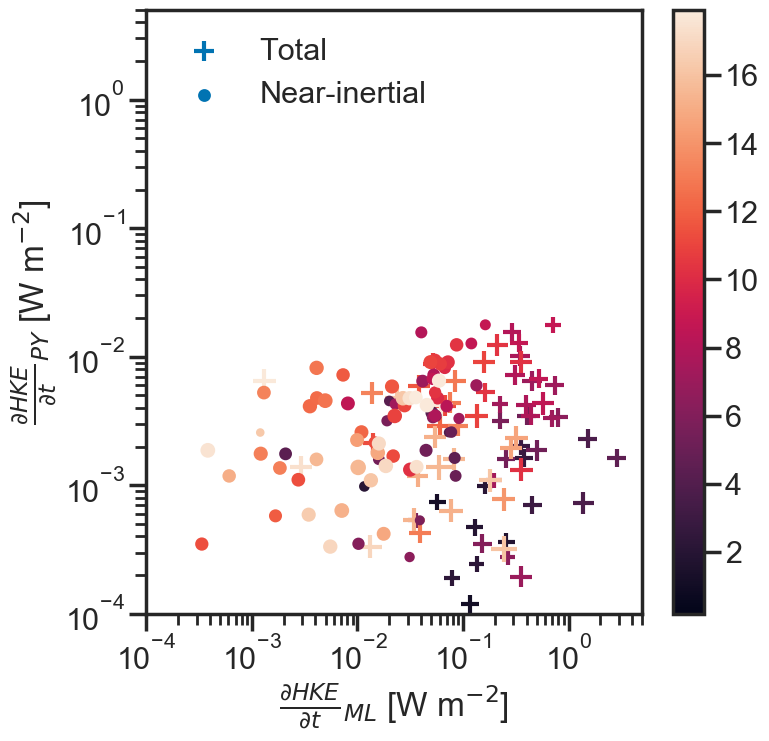

In [2405]:
plt.figure(figsize=(8,8))
plt.scatter(raw.dhke_ml,raw.dhke_py_ni,c=raw.dtime.values/86400, s=raw.mld.values*(-5), marker='+', label='Total')
plt.scatter(raw.dhke_ml_ni,raw.dhke_py_ni,c=raw.dtime.values/86400, s=raw.mld.values*(-5), marker='.', label='Near-inertial')

# plt.scatter(raw.dhke_ml,raw.dhke_py, marker='.', label='Total')
# plt.scatter(raw.dhke_ml_ni,raw.dhke_py_ni, marker='.', label='Near-inertial')
plt.colorbar()
# plt.scatter(raw.dhke_ml_ni,raw.dhke_py_ni, marker='.', label='Near-inertial')

# plt.plot(raw.dhke_ml_ni,raw.dhke_ml_ni**0.5, marker='.', lw=0, label='Near-inertial')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,5e0)
plt.ylim(1e-4,5e0)
# plt.axis('equal')
plt.xlabel(r'$\frac{\partial HKE}{\partial t}_{ML}$ [W m$^{-2}$]')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}_{PY}$ [W m$^{-2}$]')
plt.legend(loc=2)

## Wind work $\mathbf{\tau} \cdot \mathbf{u}$

In [2177]:
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
cfs = cfs.interp_like(raw).sel(time=slice('2016-10-01','2016-10-21'))

In [2265]:
# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0)
indv = first_finite(raw.v, 0)
raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

# extract uppermost velocity measuremnt
indu = first_finite(raw.uNI, 0)
indv = first_finite(raw.vNI, 0)
raw['u_surf_ni'] = raw.uNI[indu]
raw['v_surf_ni'] = raw.vNI[indv]



raw['tx'] = ('time', -cfs['tx'])
raw['ty'] = ('time', -cfs['ty'])

f = gsw.f(40.7)/(2*np.pi)
raw = bandpass_variable(raw,'tx', 0.75*f, 1.25*f)
raw = bandpass_variable(raw,'ty', 0.75*f, 1.25*f)

raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['taudotu_ni'] = raw.u_surf_ni * raw.tx + raw.v_surf_ni * raw.ty
raw['taudotu_ni_ni'] = raw.u_surf_ni * raw.txNI + raw.v_surf_ni * raw.tyNI
raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))

0.14528610105438827
0.24214350175731378
0.14528610105438827
0.24214350175731378


../src/tools.py:163: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  deltat = data.time[j] - data.time[j - 1]
../src/tools.py:163: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  deltat = data.time[j] - data.time[j - 1]


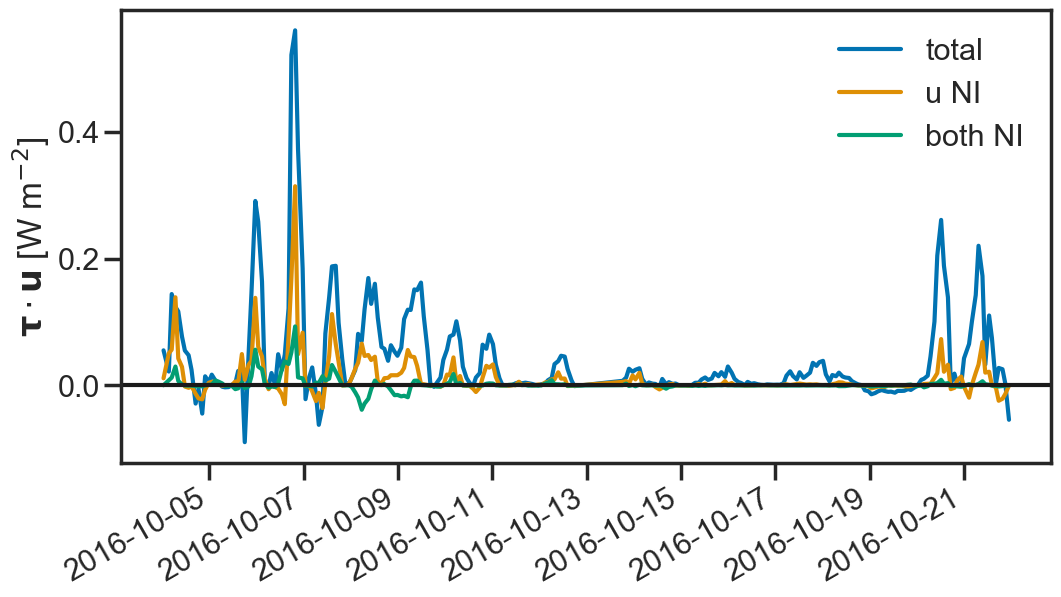

In [2266]:
# raw.tau.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tau')
raw.taudotu.plot(label='total')
raw.taudotu_ni.plot(label='u NI')
raw.taudotu_ni_ni.plot(label='both NI')
plt.ylabel(r'$\mathbf{\tau} \cdot \mathbf{u}$ [W m$^{-2}$]')
plt.xlabel(None)
plt.axhline(0, color='k')
plt.legend()
# plt.yscale('log')

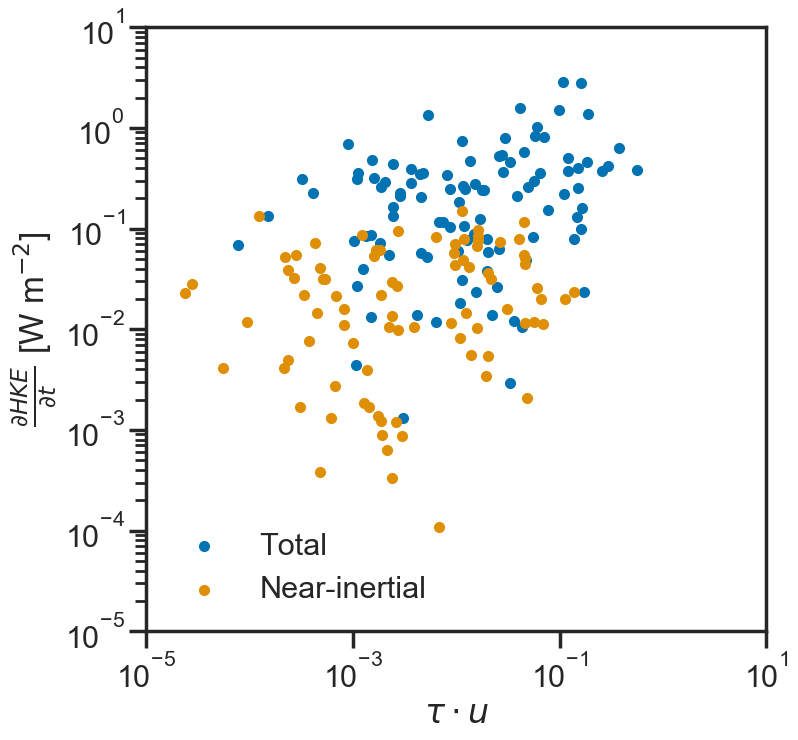

In [2188]:
plt.figure(figsize=(8,8))
plt.scatter(raw.taudotu,raw.dhke_ml, marker='.', label='Total')
plt.scatter(raw.taudotu_ni,raw.dhke_ml_ni, marker='.', label='Near-inertial')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-5,1e1)
plt.ylim(1e-5,1e1)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')
plt.legend();

In [2207]:
def compute_spectra_cfs(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array], dim='dtime', fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

In [2211]:
tau_spec = compute_spectra_cfs(raw,'tau').mean('dtime')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  after removing the cwd from sys.path.


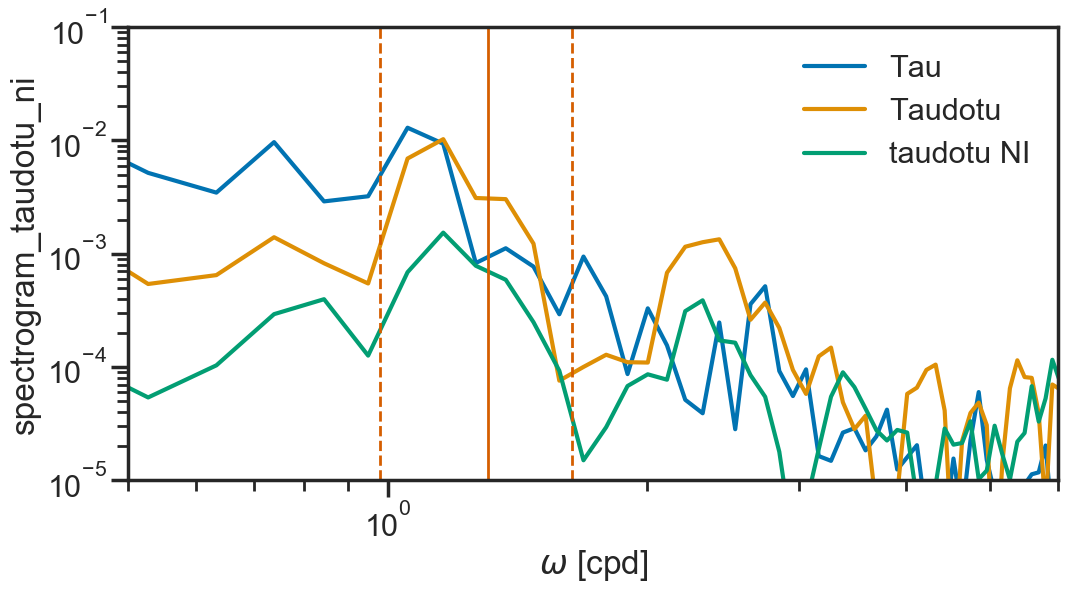

In [2215]:
compute_spectra_cfs(raw,'tau').mean('dtime').plot(label='Tau')
compute_spectra_cfs(raw,'taudotu').mean('dtime').plot(label='Taudotu')
compute_spectra_cfs(raw,'taudotu_ni').mean('dtime').plot(label='taudotu NI')

latmean = 40.7
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')


plt.xlim(5e-1,6e0)
plt.ylim(1e-5,1e-1)
plt.title(None);
plt.xlabel('$\omega$ [cpd]')
plt.xscale('log')
plt.yscale('log')
plt.legend();

## Availabel potential energy (APE)

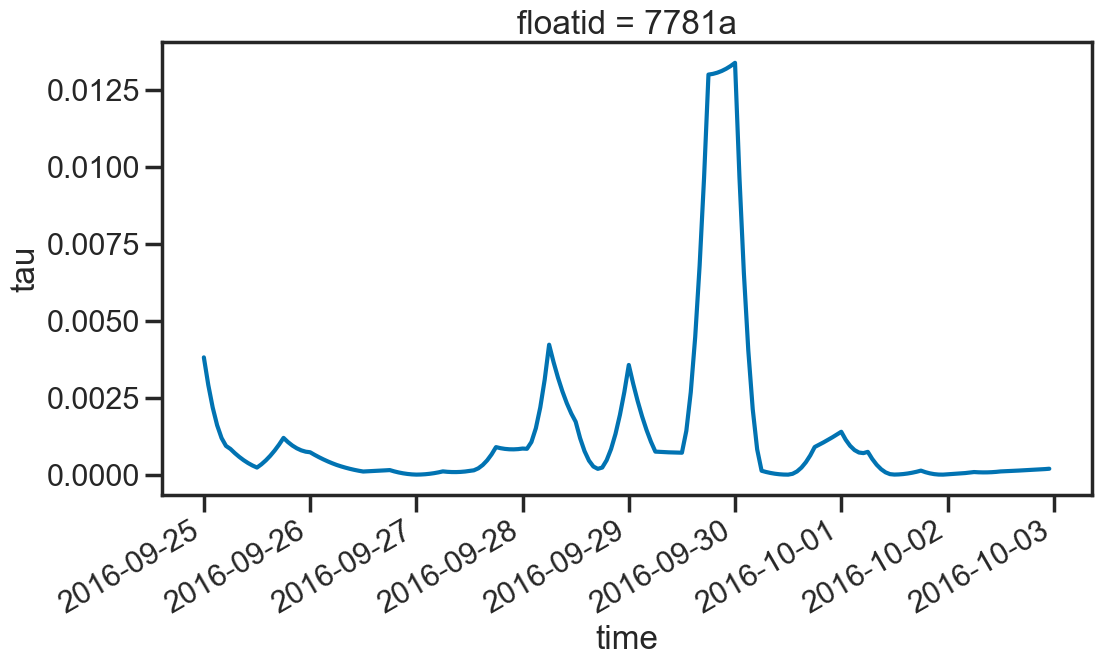

In [2264]:
background_cfs.tau.plot()

In [2513]:
from tools import lowpass_variable

In [2514]:
f = gsw.f(40.7)/(2*np.pi)
raw = lowpass_variable(raw,'rho0', 0.75*f, 1.25*f)

0.14528610105438827
0.24214350175731378


../src/tools.py:241: UnevenSamplingWarning: Average sampling 6.4e+03 != first sampling step 9.73e+03
  T = ( dsp.get_sampling_step(raw, dim='dtime') )


(-100, 0)

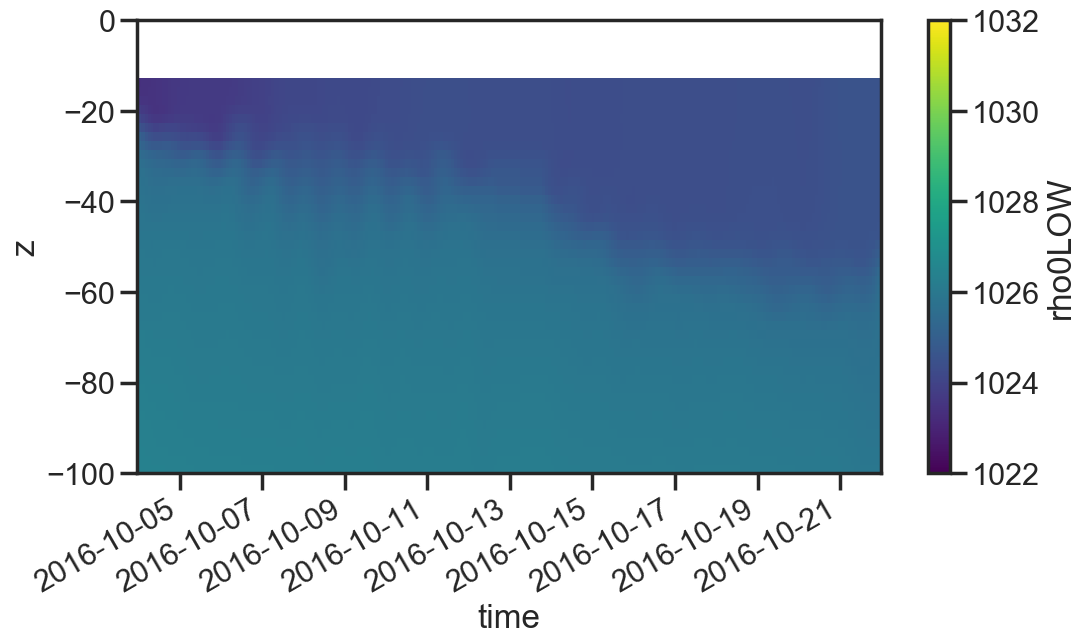

In [2515]:
raw.rho0LOW.plot(vmin=1022,vmax=1032)
plt.ylim(-100,0)

(-200, 0)

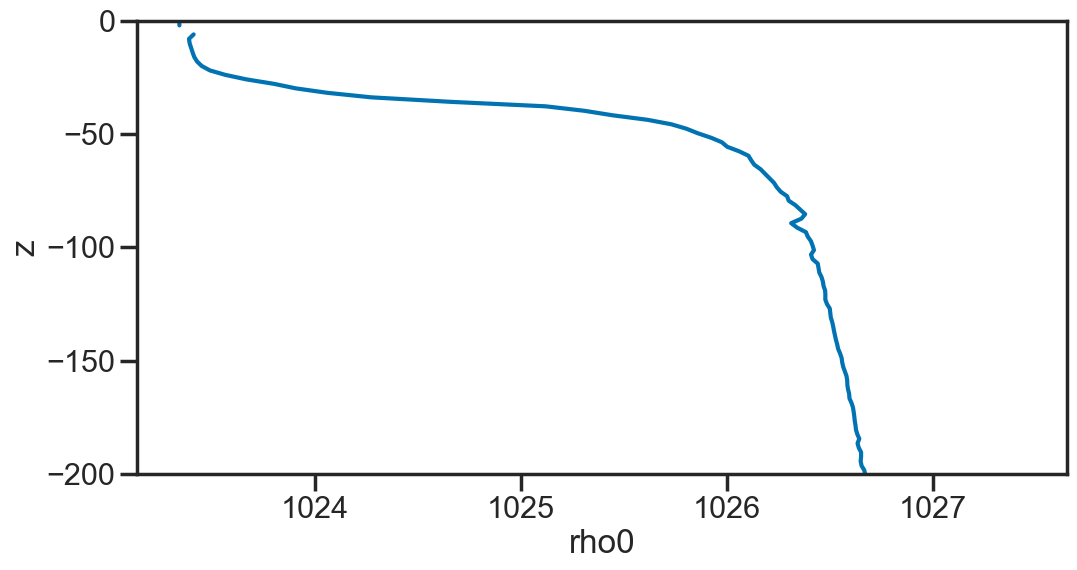

In [2516]:
background_raw.rho0.mean('time').sortby('z').plot(y='z')
plt.ylim(-200,0)

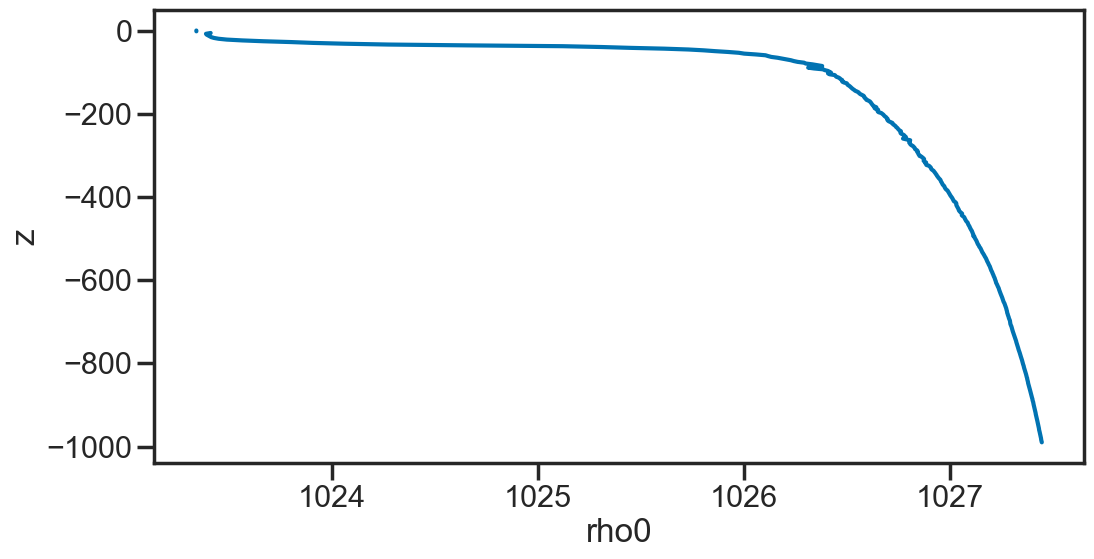

In [2517]:
background_raw.rho0.mean('time',skipna=True).plot(y='z')

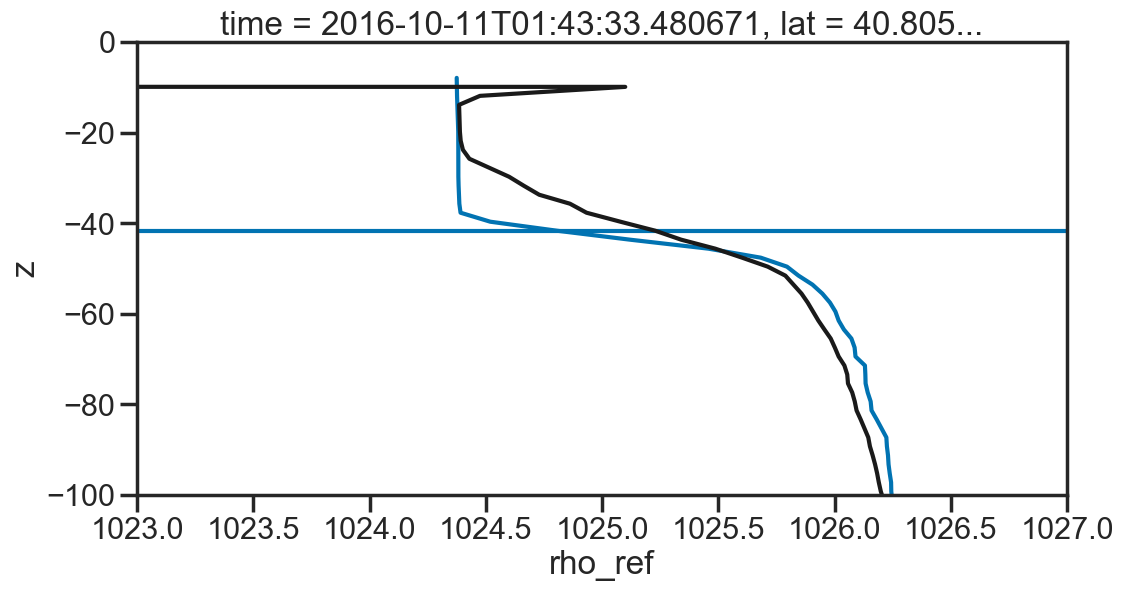

In [2526]:

# for i in range(200,210):
#     (raw.rho0.isel(time=i)).plot(y='z')
i=100
(raw.rho0.isel(time=i)).plot(y='z')
plt.axhline(raw.mld.isel(time=i))
plt.ylim(-100,0)
plt.xlim(1023,1027)
raw.rho_ref.isel(time=i).plot(y='z',color='k')

Text(0.5, 1.0, 'rho prime')

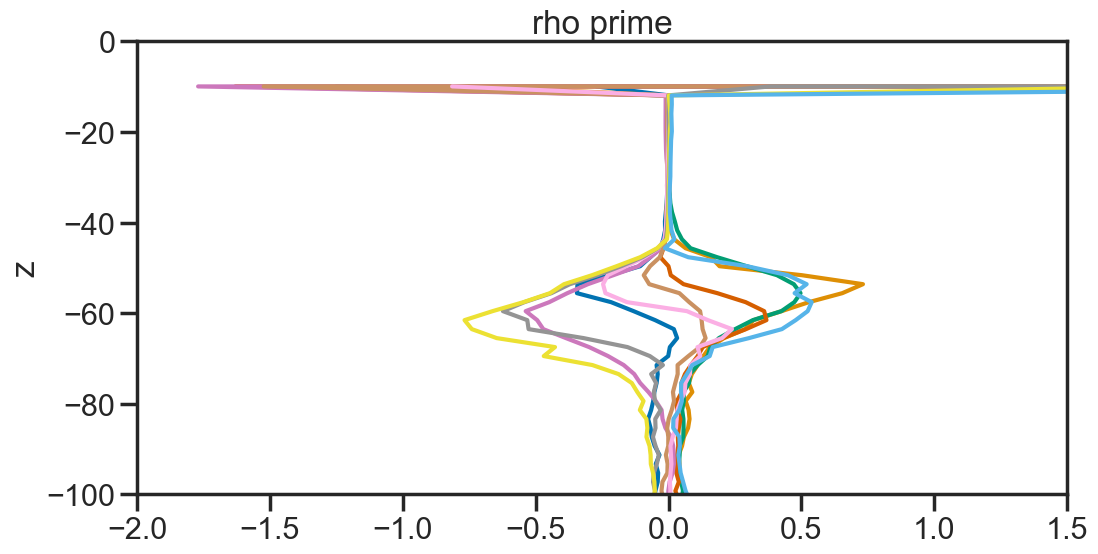

In [2523]:
for i in range(200,210):
    (raw.rho0.isel(time=i)- raw.rho_ref.isel(time=i)).plot(y='z')
plt.xlim(-2,1.5)
plt.ylim(-100,0)
plt.title('rho prime')

In [2535]:
# raw['rho_ref'] = raw.rho0.rolling(time=5, center=True).mean()
# raw['rho_ref'] = background_raw.rho0.mean('time')
raw['rho_ref'] = raw.rho0LOW
raw['rho_prime'] = raw.rho0 - raw.rho_ref
raw['rho_prime'] = raw.rho_prime.where(raw.z<-15,0).where(raw.z>-450,0)

(-600, 0)

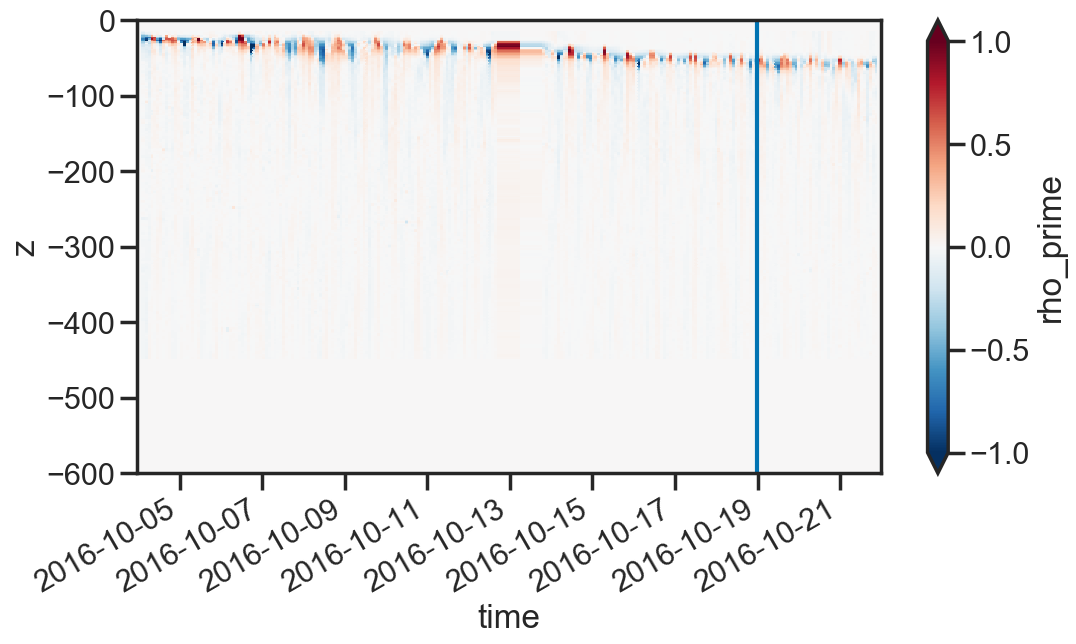

In [2536]:
raw.rho_prime.plot(vmin=-1,vmax=1, cmap='RdBu_r')
plt.axvline(raw.time.isel(time=200).values)
plt.ylim(-600,0)

In [2546]:
array = []
for t in range(raw.time.size):
    # TODO: could do better here with simpson's rule
    prof = raw.isel(time=t)
    prof = prof.dropna(dim='z', how='any', subset=['rho_prime','rho0','rho_ref'])
    prof = prof[['rho_ref','rho0','rho_prime']]
    
    proff = prof.swap_dims({'z':'rho_ref'}).sortby('rho_ref')
    if prof.rho_ref.size>0:
        prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)
        prof['ape'] = ('z', compute_ape(prof) )
        array.append(prof)
    else:
        array.append(np.nan)
        
cleanedList = [x for x in array if type(x)!=float]
new = xr.concat(cleanedList, dim='time')

In [2547]:
raw['ape'] = new.ape.transpose()
raw['hke_ape'] = raw.hkeNI/raw.ape

Text(0, 0.5, 'Depth [m]')

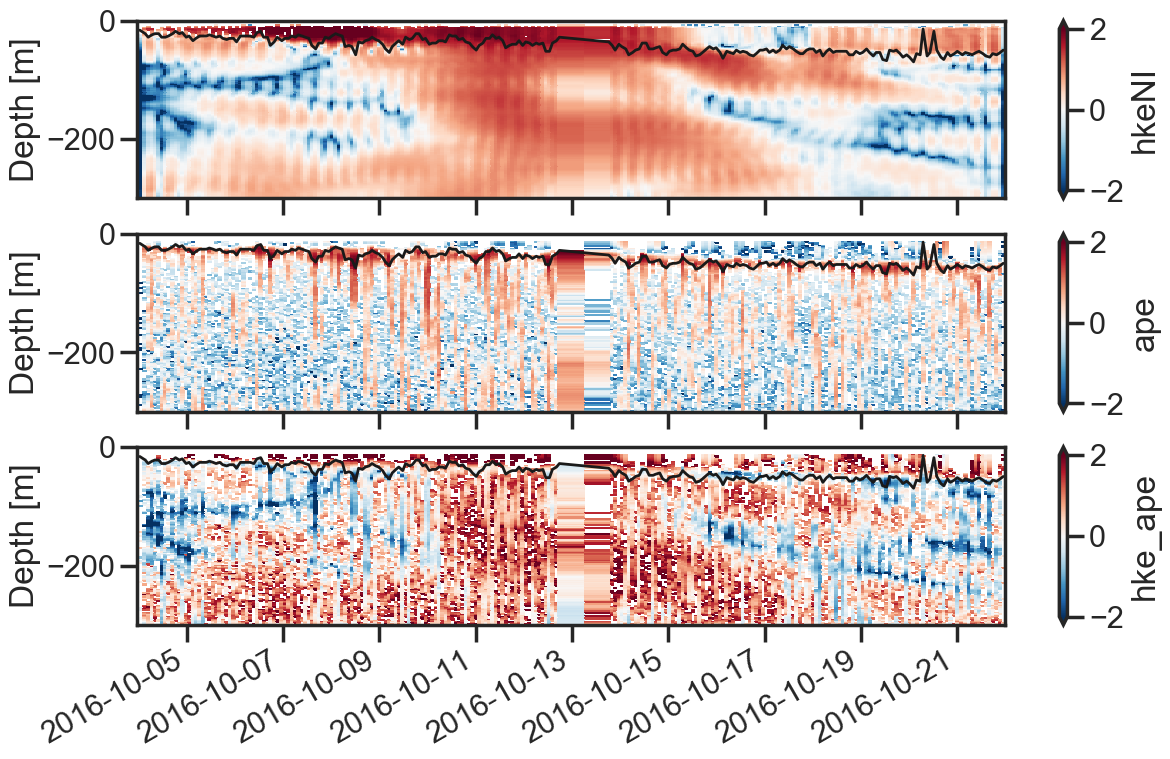

In [2597]:
f, ax = plt.subplots(3,1, sharex=True, figsize=(14,8))

raw.hkeNI.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', ax=ax[0])
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-300,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


raw.ape.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', ax=ax[1])
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-300,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

raw.hke_ape.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', ax=ax[2])
raw.mld.plot(color='k', lw=2, ax=ax[2])
ax[2].set_ylim(-300,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth [m]')

In [2598]:
2*np.pi/gsw.f(40.7)/3600

18.351886968768387

In [2599]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['ape_ml'] = raw.ape.where(ml_mask).mean(dim='z')
raw['ape_py'] = raw.ape.where(py_mask).mean(dim='z')

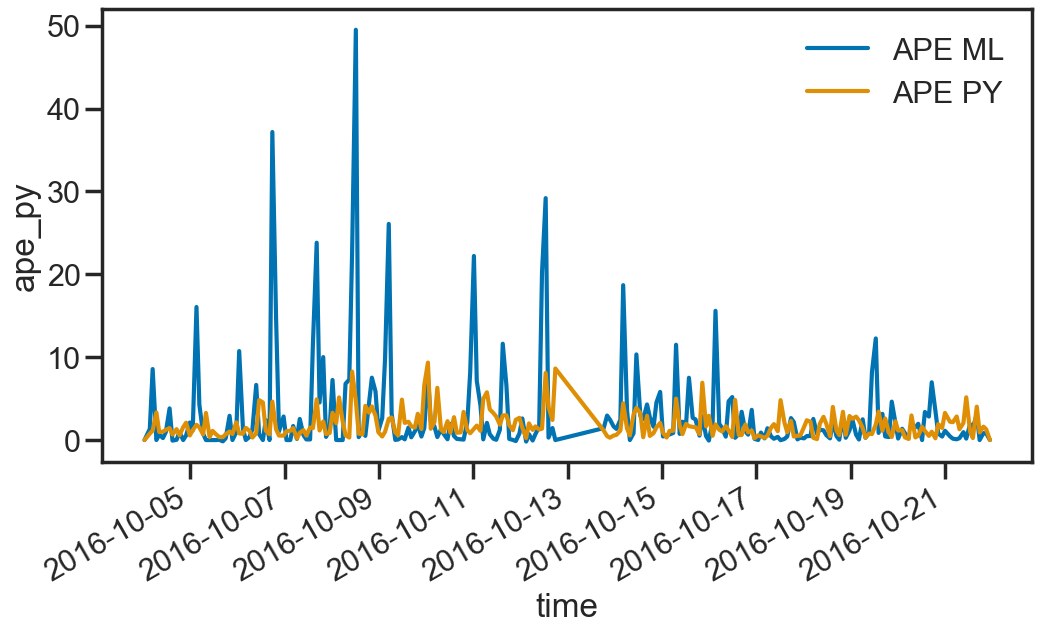

In [2601]:
(raw.ape_ml).plot(label='APE ML')
(raw.ape_py).plot(label='APE PY')
plt.legend()

In [2606]:
raw['dape_ml'] = (-raw['ape_ml']*raw.mld).differentiate('time',datetime_unit='s')
raw['dape_py'] =(raw['ape_py']*(400+raw.mld)).differentiate('time',datetime_unit='s')

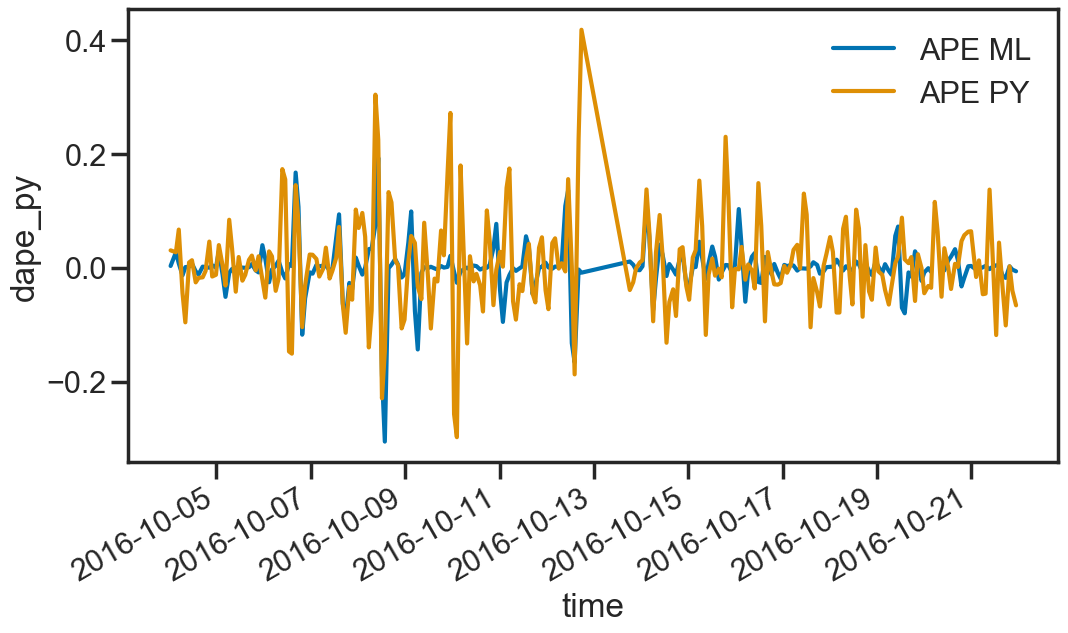

In [2607]:
raw.dape_ml.plot(label='APE ML')
raw.dape_py.plot(label='APE PY')
plt.legend()

Text(0, 0.5, '$\\frac{\\partial HKE}{\\partial t}$ [W m$^{-2}$]')

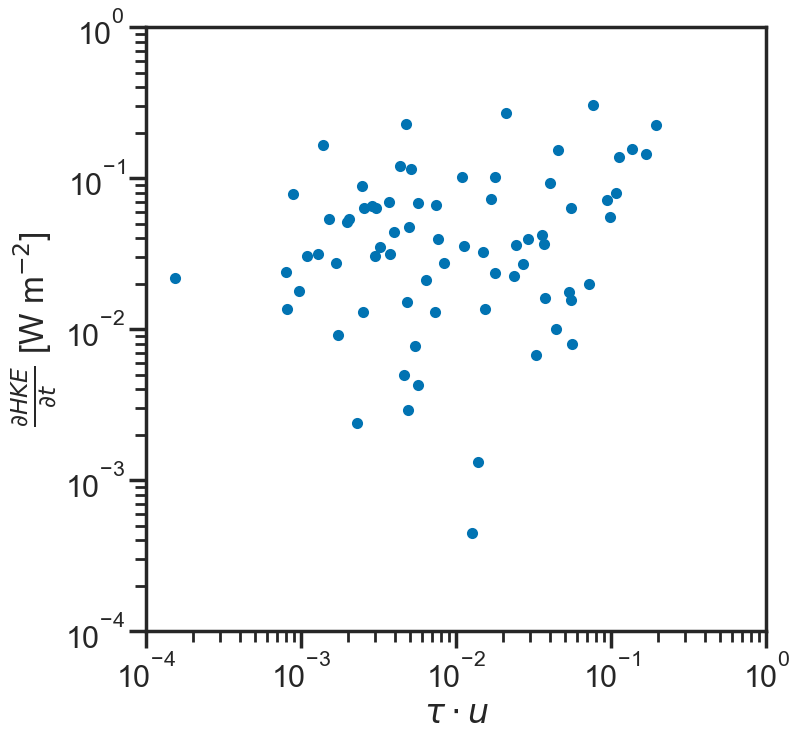

In [2608]:
plt.figure(figsize=(8,8))
plt.scatter(raw.dape_ml,raw.dape_py, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial HKE}{\partial t}$ [W m$^{-2}$]')

Text(0, 0.5, '$\\frac{\\partial APE}{\\partial t}$ [W m$^{-2}$]')

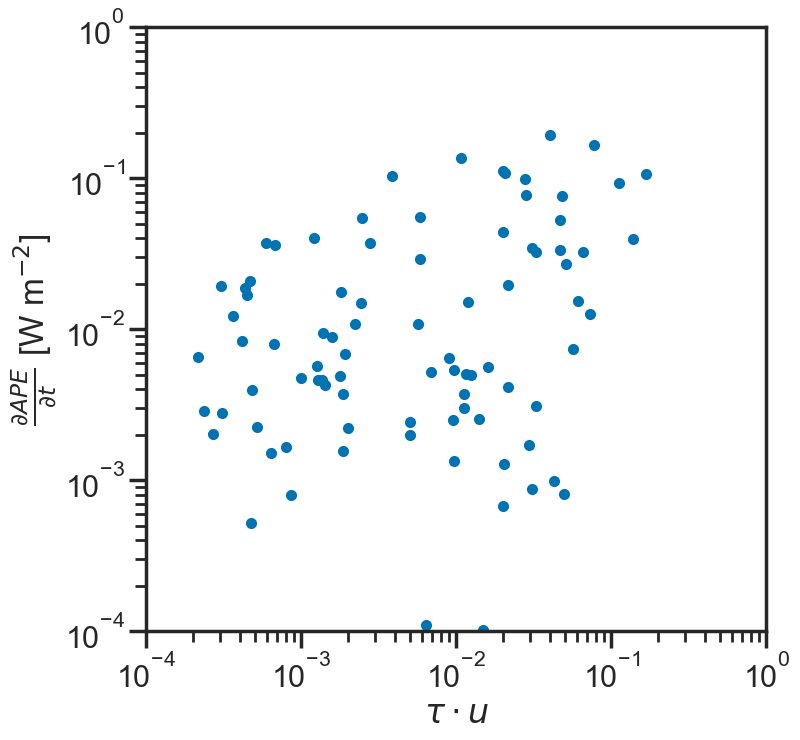

In [2611]:
plt.figure(figsize=(8,8))
plt.scatter(raw.taudotu_ni,raw.dape_ml, marker='.')
# plt.scatter(raw.taudotu,raw.dhke_ml, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)
plt.ylim(1e-4,1e0)
# plt.axis('equal')
plt.xlabel(r'$\tau \cdot u$')
plt.ylabel(r'$\frac{\partial APE}{\partial t}$ [W m$^{-2}$]')

## Epsilon $\epsilon$

In [2360]:
raw = qc_turbulence(raw)

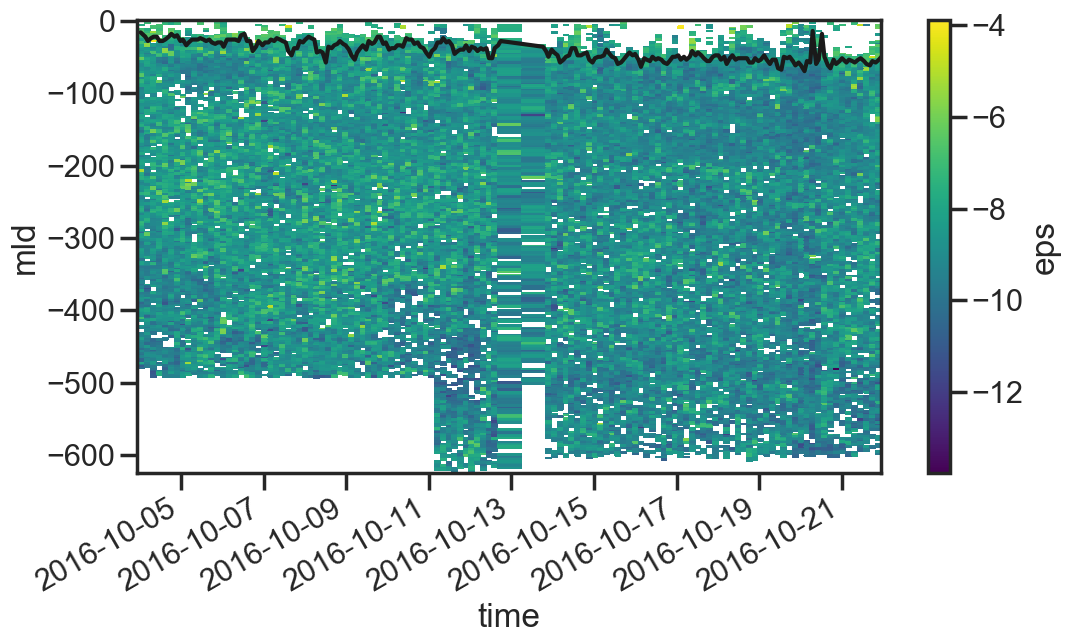

In [2361]:
raw.eps.dropna('time', how='all').dropna('z', how='all').pipe(np.log10).plot()
raw.mld.plot(color='k')

In [2362]:
# just to check takes simple averages
ml_mask = (raw.z>raw.mld) & (raw.z<0)
py_mask = (raw.z>zmin) & (raw.z<raw.mld)
raw['eps_ml'] = raw.eps.where(ml_mask).fillna(0).mean(dim='z')
raw['eps_py'] = raw.eps.where(py_mask).fillna(0).mean(dim='z')

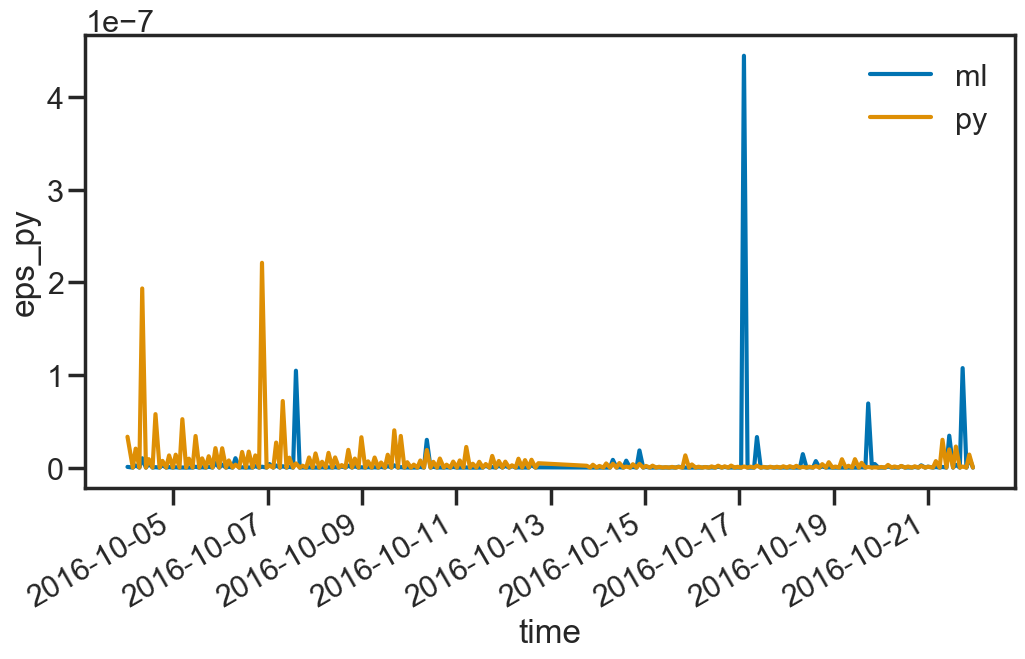

In [2363]:
raw['eps_ml'].plot(label='ml')
raw['eps_py'].plot(label='py')
plt.legend();

## Compare all terms togther

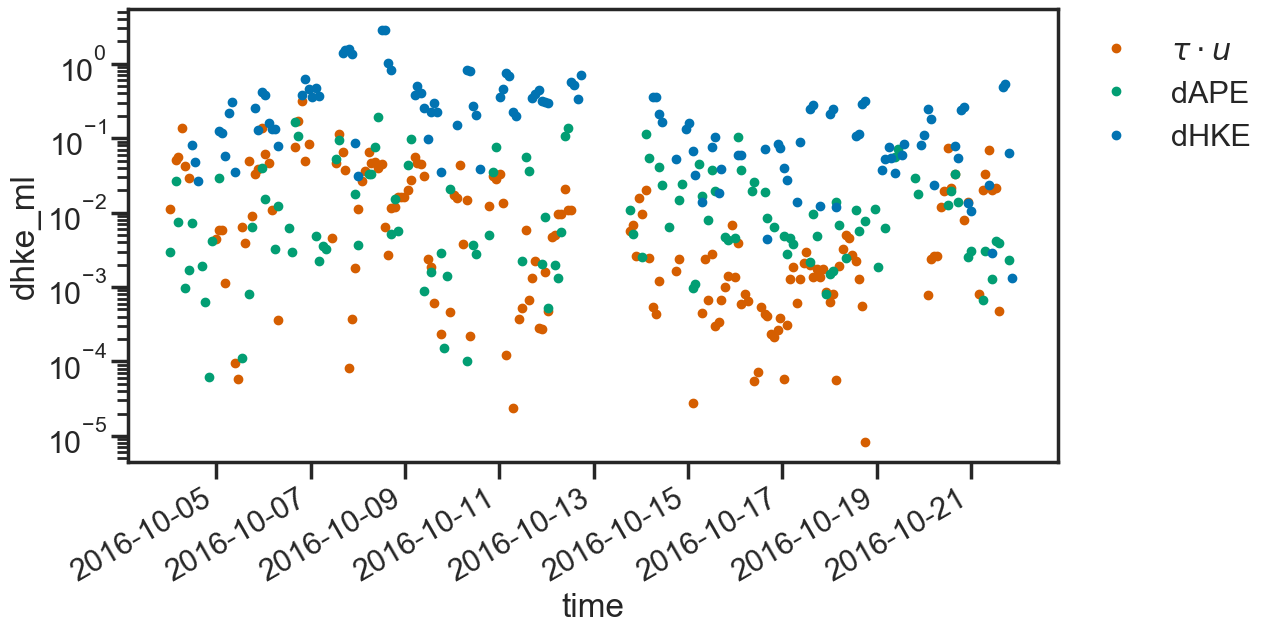

In [2612]:
raw.taudotu_ni.plot(label=r'$\tau \cdot u$',lw=0, marker='.', color='r')
# raw.taudotu_ni.rolling(time=7).mean().plot(label=r'_$\tau \cdot u$',lw=0, marker='.', color='r')

raw.dape_ml.plot(label='dAPE',lw=0, marker='.',color='g')
# raw.dape_ml.rolling(time=7).mean().plot(label='_dAPE',lw=0, marker='.', color='g')

raw.dhke_ml.plot(label='dHKE',lw=0, marker='.', color='b')
# raw.dhke_ml.rolling(time=7).mean().plot(label='_dHKE',lw=0, marker='.', color='b')

# raw.eps_ml.pipe(lambda x: x*1e3).plot(label='eps',lw=0, marker='.', color='C1')
# raw.eps_ml.rolling(time=7).mean().pipe(lambda x: x*1e3).plot(label='_eps',lw=0, marker='.', color='C1')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.yscale('log')

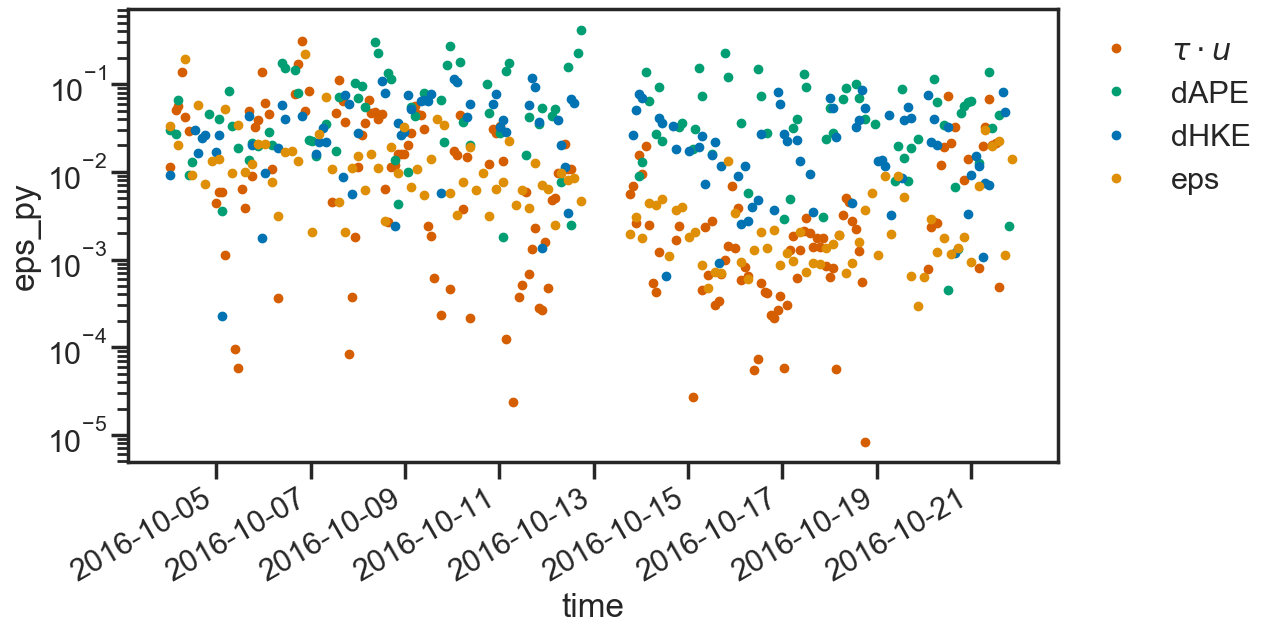

In [2618]:
raw.taudotu_ni.pipe(lambda x: x).plot(label=r'$\tau \cdot u$',lw=0, marker='.', color='r')
raw.dape_py.plot(label='dAPE',lw=0, marker='.', color='g')
raw.dhke_py.plot(label='dHKE',lw=0, marker='.', color='b')
raw.eps_py.pipe(lambda x: x*1e6).plot(label='eps',lw=0, marker='.', color='C1')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.yscale('log')